# Graph Neural Network Baseline - Regression Task on Traffic Dataset

This notebook implements a simple deterministic Graph Neural Network (GNN) baseline for comparison with GP methods.

The GNN uses:
1. Message passing layers to aggregate neighbor information
2. Graph convolution operations on the traffic network
3. Multiple layers for learning hierarchical representations
4. Deterministic predictions (mean only, no uncertainty estimation)

## Setup

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import tensorflow_probability as tfp
from tqdm import tqdm
import pandas as pd

import sys
import os
project_root = os.path.abspath("../..")
sys.path.append(project_root)

from traffic_utils.preprocessing import load_PEMS

# Set random seeds for reproducibility
np.random.seed(1111)
tf.random.set_seed(1111)

2025-11-16 15:26:10.434643: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-16 15:26:10.447078: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763306770.461404 2646652 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763306770.466093 2646652 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1763306770.476734 2646652 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
os.chdir('../..')

In [3]:
!ls

algorithms	    efficient_graph_gp_sparse  presentations   requirements.txt
Archive		    experiments_dense	       processed_data  setup.py
data		    experiments_sparse	       __pycache__     utils.py
efficient_graph_gp  graph_bo		       README.md       venv


In [4]:
# Load and preprocess the PEMS dataset

num_train = 250

G, data_train, data_test, data = load_PEMS(num_train=num_train)
x_train, y_train = data_train
x_test, y_test = data_test
x, y = data
orig_mean, orig_std = np.mean(y_train), np.std(y_train)
y_train = (y_train-orig_mean)/orig_std
y_test = (y_test-orig_mean)/orig_std

# Extract node indices
train_nodes = x_train[:, 0].astype(int)  # First column contains node indices
test_nodes = x_test[:, 0].astype(int)
all_nodes = x[:, 0].astype(int)

# Full graph adjacency
adjacency_matrix = nx.to_numpy_array(G)
num_nodes = adjacency_matrix.shape[0]

# Create feature matrices for all nodes (initialize with zeros, fill in observed values)
X_full = np.zeros((num_nodes, x.shape[1]))
Y_full_train = np.zeros((num_nodes, 1))
Y_full_test = np.zeros((num_nodes, 1))

X_full[all_nodes] = x
Y_full_train[train_nodes] = y_train
Y_full_test[test_nodes] = y_test

X_full_tensor = tf.constant(X_full, dtype=tf.float32)
Y_train_tensor = tf.constant(Y_full_train, dtype=tf.float32)
Y_test_tensor = tf.constant(Y_full_test, dtype=tf.float32)

print(f"Full adjacency matrix shape: {adjacency_matrix.shape}")
print(f"Full feature matrix shape: {X_full_tensor.shape}")
print(f"Training nodes: {len(train_nodes)}, Test nodes: {len(test_nodes)}")

/scratches/cartwright/mz473/Efficient-Gaussian-Process-on-Graphs/experiments_dense/traffic_dataset/traffic_utils/preprocessing.py:90: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again as this compatibility may be removed in a future version of shapely.
  G = pickle.load(f)


epsg:4326
Full adjacency matrix shape: (1016, 1016)
Full feature matrix shape: (1016, 1)
Training nodes: 250, Test nodes: 75
Full adjacency matrix shape: (1016, 1016)
Full feature matrix shape: (1016, 1)
Training nodes: 250, Test nodes: 75


I0000 00:00:1763306794.372703 2646652 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 614 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:17:00.0, compute capability: 7.5
I0000 00:00:1763306794.374250 2646652 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 9457 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:b3:00.0, compute capability: 7.5


## GNN Model Implementation

We implement a Graph Convolutional Network (GCN) for regression on the traffic network.

In [5]:
class GraphConvLayer(tf.keras.layers.Layer):
    """Graph Convolution Layer with message passing."""
    
    def __init__(self, units, activation='relu', use_bias=True, **kwargs):
        super(GraphConvLayer, self).__init__(**kwargs)
        self.units = units
        self.activation = tf.keras.activations.get(activation)
        self.use_bias = use_bias
        
    def build(self, input_shape):
        # Weight matrix for feature transformation
        self.kernel = self.add_weight(
            name='kernel',
            shape=(input_shape[-1], self.units),
            initializer='glorot_uniform',
            trainable=True
        )
        if self.use_bias:
            self.bias = self.add_weight(
                name='bias',
                shape=(self.units,),
                initializer='zeros',
                trainable=True
            )
        super(GraphConvLayer, self).build(input_shape)
    
    def call(self, inputs, adjacency):
        """
        Args:
            inputs: Node features [num_nodes, input_dim]
            adjacency: Adjacency matrix [num_nodes, num_nodes]
        """
        # Normalize adjacency matrix: D^(-1/2) * A * D^(-1/2)
        degree = tf.reduce_sum(adjacency, axis=1)
        degree = tf.where(degree == 0, tf.ones_like(degree), degree)
        d_inv_sqrt = tf.pow(degree, -0.5)
        d_inv_sqrt = tf.linalg.diag(d_inv_sqrt)
        
        adj_normalized = tf.matmul(tf.matmul(d_inv_sqrt, adjacency), d_inv_sqrt)
        
        # Add self-connections
        adj_normalized = adj_normalized + tf.eye(tf.shape(adjacency)[0], dtype=adjacency.dtype)
        
        # Graph convolution: A_norm * X * W
        support = tf.matmul(inputs, self.kernel)
        output = tf.matmul(adj_normalized, support)
        
        if self.use_bias:
            output = output + self.bias
            
        return self.activation(output)


class GNNRegressor(tf.keras.Model):
    """Simple deterministic GNN model for regression on graphs."""
    
    def __init__(self, hidden_dims=[64, 32, 16], dropout_rate=0.1):
        super(GNNRegressor, self).__init__()
        self.hidden_dims = hidden_dims
        self.dropout_rate = dropout_rate
        
        # Graph convolution layers
        self.conv_layers = []
        for dim in hidden_dims:
            self.conv_layers.append(GraphConvLayer(dim, activation='relu'))
        
        # Dropout layers
        self.dropout_layers = [tf.keras.layers.Dropout(dropout_rate) for _ in hidden_dims]
        
        # Output layer (deterministic prediction)
        self.output_layer = tf.keras.layers.Dense(1, activation=None)
        
    def call(self, inputs, adjacency, training=False):
        """
        Args:
            inputs: Node features [num_nodes, input_dim]
            adjacency: Adjacency matrix [num_nodes, num_nodes]
            training: Boolean for dropout
        """
        x = inputs
        
        # Apply graph convolution layers with dropout
        for conv, dropout in zip(self.conv_layers, self.dropout_layers):
            x = conv(x, adjacency)
            if training:
                x = dropout(x, training=training)
        
        # Output predictions
        output = self.output_layer(x)
        
        return output

In [6]:
def gnn_loss(y_true, y_pred, node_mask):
    """
    MSE loss for GNN.
    Only compute loss on masked nodes.
    """
    # Apply mask to only compute loss on training nodes
    mask_float = tf.cast(tf.reshape(node_mask, [-1, 1]), tf.float32)
    
    # MSE loss (only for masked nodes)
    squared_error = tf.square(y_true - y_pred)
    mse = tf.reduce_sum(mask_float * squared_error) / (tf.reduce_sum(mask_float) + 1e-10)
    
    return mse


def train_gnn(model, X_full, Y_train, adjacency, train_nodes,
              num_epochs=500, learning_rate=0.001):
    """
    Train GNN model on full graph, computing loss only on training nodes.
    """
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    adjacency_tensor = tf.constant(adjacency, dtype=tf.float32)
    
    # Create mask for training nodes
    num_nodes = adjacency.shape[0]
    train_mask = np.zeros(num_nodes, dtype=bool)
    train_mask[train_nodes] = True
    train_mask_tensor = tf.constant(train_mask, dtype=tf.bool)
    
    losses = []
    
    for epoch in tqdm(range(num_epochs), desc='Training GNN'):
        with tf.GradientTape() as tape:
            # Forward pass on all nodes
            predictions = model(X_full, adjacency_tensor, training=True)
            
            # Compute loss only on training nodes
            loss = gnn_loss(Y_train, predictions, train_mask_tensor)
        
        # Backward pass
        gradients = tape.gradient(loss, model.trainable_variables)
        
        # Check for NaN gradients
        if any(tf.reduce_any(tf.math.is_nan(g)) if g is not None else False for g in gradients):
            print(f"Warning: NaN gradients at epoch {epoch}")
            break
            
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        
        losses.append(loss.numpy())
        
        if epoch % 50 == 0:
            print(f"Epoch {epoch}: Loss = {loss.numpy():.6f}")
    
    return model, losses


def evaluate_gnn(model, X_full, Y_test, adjacency, test_nodes, orig_std):
    """
    Evaluate GNN model on test nodes (RMSE only).
    """
    adjacency_tensor = tf.constant(adjacency, dtype=tf.float32)
    
    # Get predictions for all nodes
    predictions = model(X_full, adjacency_tensor, training=False)
    
    # Extract predictions for test nodes only
    pred_test = tf.gather(predictions, test_nodes)
    y_test = tf.gather(Y_test, test_nodes)
    
    # Compute RMSE (denormalized)
    pred_flat = tf.reshape(pred_test, [-1])
    y_test_flat = tf.reshape(y_test, [-1])
    
    # Check for NaN values
    if tf.reduce_any(tf.math.is_nan(pred_flat)):
        print("Warning: NaN values in predictions")
        return np.nan
    
    rmse = float(orig_std * tf.sqrt(tf.reduce_mean(tf.square(y_test_flat - pred_flat))))
    
    print(f"\nTest RMSE: {rmse:.4f}")
    
    return rmse

## Train and Evaluate GNN Model

In [7]:
# Create and train GNN model
gnn_model = GNNRegressor(hidden_dims=[64, 32, 16], dropout_rate=0.1)

# Check input shapes
print(f"X_full shape: {X_full_tensor.shape}")
print(f"Y_train shape: {Y_train_tensor.shape}")
print(f"Adjacency shape: {adjacency_matrix.shape}")
print(f"Train nodes: {len(train_nodes)}")

trained_gnn, losses = train_gnn(
    gnn_model, 
    X_full_tensor, 
    Y_train_tensor, 
    adjacency_matrix,
    train_nodes,
    num_epochs=500,
    learning_rate=0.001
)

X_full shape: (1016, 1)
Y_train shape: (1016, 1)
Adjacency shape: (1016, 1016)
Train nodes: 250


Training GNN:   0%|          | 0/500 [00:00<?, ?it/s]

Training GNN:   1%|          | 3/500 [00:02<05:09,  1.60it/s]

Epoch 0: Loss = 168667.703125


Training GNN:  11%|█         | 54/500 [00:04<00:19, 23.44it/s]

Epoch 50: Loss = 2766.885254


Training GNN:  21%|██        | 104/500 [00:07<00:20, 19.13it/s]

Epoch 100: Loss = 1135.033447


Training GNN:  31%|███       | 154/500 [00:10<00:19, 17.73it/s]

Epoch 150: Loss = 470.459076


Training GNN:  41%|████      | 203/500 [00:12<00:17, 17.24it/s]

Epoch 200: Loss = 190.670044


Training GNN:  51%|█████     | 253/500 [00:15<00:10, 23.05it/s]

Epoch 250: Loss = 57.961079


Training GNN:  61%|██████    | 303/500 [00:18<00:12, 15.71it/s]

Epoch 300: Loss = 34.869469


Training GNN:  71%|███████   | 353/500 [00:20<00:07, 18.81it/s]

Epoch 350: Loss = 11.634896


Training GNN:  81%|████████  | 404/500 [00:23<00:05, 18.01it/s]

Epoch 400: Loss = 3.827088


Training GNN:  91%|█████████ | 453/500 [00:26<00:02, 17.13it/s]

Epoch 450: Loss = 6.171014


Training GNN: 100%|██████████| 500/500 [00:30<00:00, 16.65it/s]


In [8]:
# Evaluate on test set
rmse = evaluate_gnn(trained_gnn, X_full_tensor, Y_test_tensor, adjacency_matrix, test_nodes, orig_std)


Test RMSE: 18.4727


## Visualize Training Loss

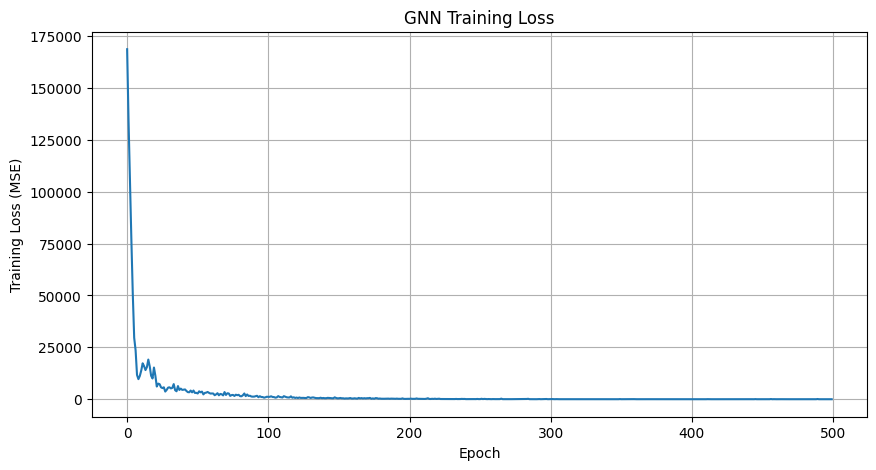

In [9]:
plt.figure(figsize=(10, 5))
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Training Loss (MSE)')
plt.title('GNN Training Loss')
plt.grid(True)
plt.show()

## Save Results

In [10]:
# Save results to CSV for comparison with GP methods
results = {
    'seed': 1111,
    'model': 'GNN_deterministic',
    'rmse': rmse,
    'num_params': sum([tf.size(v).numpy() for v in trained_gnn.trainable_variables])
}

results_df = pd.DataFrame([results])
print("\nGNN Results:")
print(results_df)

# Save to file
os.makedirs('experiments_dense/traffic_dataset/results', exist_ok=True)
results_df.to_csv('experiments_dense/traffic_dataset/results/gnn_results.csv', index=False)
print("\nResults saved to experiments_dense/traffic_dataset/results/gnn_results.csv")


GNN Results:
   seed              model       rmse  num_params
0  1111  GNN_deterministic  18.472675        2753

Results saved to experiments_dense/traffic_dataset/results/gnn_results.csv


In [11]:
# Model summary
print("\nGNN Model Summary:")
print(f"Number of trainable parameters: {sum([tf.size(v).numpy() for v in trained_gnn.trainable_variables])}")
print(f"Hidden dimensions: {trained_gnn.hidden_dims}")
print(f"Dropout rate: {trained_gnn.dropout_rate}")


GNN Model Summary:
Number of trainable parameters: 2753
Hidden dimensions: [64, 32, 16]
Dropout rate: 0.1
